## Retrospective and near real-time monitoring of weather hazards

This section outlines the specific atmospheric hazards we monitor using satellite data, focusing on air quality and lightning phenomena. Understanding these hazards is crucial for predicting, observing, and mitigating their impacts on the environment and human health.

### Air Quality: Dust, Smoke, Fire
- **ABI - L2 - ADPC** - Advanced Baseline Imager Level 2 Aerosol Detection CONUS:
  - This dataset is utilized for detecting aerosols such as dust and smoke across the Continental United States (CONUS). Aerosols can significantly affect air quality and visibility, making their monitoring essential for public health and safety.

- **ABI - L2 - FDCC** - Advanced Baseline Imager Level 2 Fire (Hot Spot Characterization) CONUS:
  - This dataset focuses on identifying and characterizing fire hot spots. It is vital for real-time monitoring of fire outbreaks, helping to direct firefighting efforts and evaluate the environmental impact of wildfires.

### Lightning
- **GLM - L2 - LCFA** - Geostationary Lightning Mapper Level 2 Lightning Detection:
  - The GLM instrument provides data for detecting and mapping lightning events in real-time. This information is critical for weather forecasting, as lightning is a key indicator of severe storms and can pose significant risks to life and property.

In [1]:
# Import necessary Python modules and libraries for handling dates and times.
from datetime import datetime  # Provides classes for manipulating dates and times in both simple and complex ways.

# Import interactive widgets for Python to enhance Jupyter notebooks with GUI components.
import ipywidgets as widgets  # Allows for interactive widgets in the notebook for dynamic data exploration.
from IPython.display import display  # Facilitates the display of these widgets in the Jupyter notebook.

# Import the S3 filesystem interface to access data stored in S3, useful for retrieving satellite data stored in cloud services.
import s3fs  # Provides a way to access S3 files in Python using a simple filesystem interface.

# Import data handling libraries for dealing with multi-dimensional labeled datasets and data manipulation.
import xarray as xr  # Handles multi-dimensional datasets and simplifies operations on data while keeping metadata intact.
import pandas as pd  # Provides data structures and data analysis tools.
import numpy as np  # Adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

# Import Matplotlib for creating static, interactive, and animated visualizations in Python.
import matplotlib as mpl  # Base library for plotting data.
from matplotlib import pyplot as plt  # Standard plotting tool in Python, used for creating figures and plots.
import matplotlib.ticker as ticker  # Provides classes for configuring tick locations and formats on a plot.

# Import Cartopy for geospatial data processing and plotting geographic datasets.
import cartopy.crs as ccrs  # Handles coordinate reference systems and projections for mapping.
import cartopy.feature as cfeature  # Provides features such as borders, coastlines, and rivers.
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # Customizes formatting of longitude and latitude labels on geographic plots.

In [2]:
# Define a function to open a specified file as an xarray dataset.
# This function is particularly useful for handling geospatial data in formats that support metadata-rich self-describing science data.

def open_file_xarray(file):
    # Use the s3fs library to open a remote file in binary read mode.
    # This is useful for accessing large datasets stored in cloud-based storage without needing to download them locally.
    remote_file = fs.open(file, mode = 'rb')
    
    # Open the remote file using xarray with the h5netcdf engine.
    # h5netcdf is used for reading and writing netCDF4 files, leveraging the capabilities of the HDF5 file format
    # such as compression, which is essential for handling large datasets efficiently.
    dataset = xr.open_dataset(remote_file, engine = 'h5netcdf')
    
    # Return the loaded dataset to be used for further analysis or visualization.
    return dataset

# This function simplifies the process of loading satellite or model data for environmental analysis,
# making it accessible for operations such as visualization, statistical analysis, or computational modeling.

In [11]:
# Define a function to process smoke and dust detection data from the Advanced Baseline Imager (ABI) using the Aerosol Detection Product (ADP).
# This function focuses on isolating and analyzing specific pixels indicating the presence of smoke and dust.
def process_abi_adp_detection(ds):
    """
    Process ABI ADP smoke and dust detection data to isolate pixels with detected smoke or dust.

    Parameters:
    ds (xarray.Dataset): The dataset containing smoke, dust, and data quality flags (DQF).

    Returns:
    tuple: A tuple containing masked arrays for smoke and dust detections.
    """

    # Convert xarray Data Arrays to NumPy masked arrays with the correct data type.
    # This step ensures that the data is handled efficiently and can be easily manipulated using NumPy operations.
    smoke_detection = ds.Smoke.where(ds.Smoke == 1).to_masked_array().astype('uint8')
    dust_detection = ds.Dust.where(ds.Dust == 1).to_masked_array().astype('uint8')
    dqf = ds.DQF.to_masked_array().astype('uint16')

    # Use the Data Quality Flag (DQF) to refine smoke and dust detections.
    # The DQF contains bits that indicate various conditions affecting the quality of the data.

    # Mask dust pixels that are within sun-glint areas using DQF bit 6.
    # Sun-glint areas can interfere with accurate detection by reflecting sunlight, which may mimic aerosol signatures.
    # Flag values: outside sun-glint = 0, within sun-glint = 64
    dust_detection = np.ma.masked_where(dqf & 64 == 64, dust_detection)

    # Further refine the detection by excluding smoke and dust pixels outside valid solar zenith angle (SZA) or viewing zenith angle (VZA) ranges using DQF bit 7.
    # Valid angles ensure that the satellite's view and sunlight geometry are suitable for accurate detection.
    # Flag values: within valid SZA/VZA = 0, outside of valid SZA/VZA = 128
    smoke_detection = np.ma.masked_where(dqf & 128 == 128, smoke_detection)
    dust_detection = np.ma.masked_where(dqf & 128 == 128, dust_detection)

    # Return the processed smoke and dust detections as a tuple of masked arrays.
    # These arrays can be used for further analysis or visualization to understand the distribution and impact of aerosols.
    return smoke_detection, dust_detection

In [12]:
# Define a function to calculate latitude and longitude from the GOES ABI fixed grid projection using xarray.
# This function is essential for converting satellite scan angles into geographical coordinates.
def calculate_abi_lat_lon(ds):
    """
    Calculate the geographic latitude and longitude from the GOES ABI fixed grid projection coordinates.

    Parameters:
    ds (xarray.Dataset): The dataset containing the GOES ABI fixed grid projection variables.

    Returns:
    tuple: A tuple of two arrays, latitude and longitude, corresponding to each grid point on the GOES image.
    """

    # Read in GOES ABI fixed grid projection variables and constants.
    x_coordinate_1d = ds.x  # E/W scanning angle in radians
    y_coordinate_1d = ds.y  # N/S elevation angle in radians
    projection_info = ds.goes_imager_projection  # Projection constants such as satellite height and Earth radii.
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    # Create 2D coordinate matrices from 1D coordinate vectors using meshgrid, facilitating the computation across the entire grid.
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    # Compute intermediary variables needed for the latitude and longitude calculations using the projection equations.
    lambda_0 = (lon_origin * np.pi) / 180.0  # Convert origin longitude to radians
    a_var = np.power(np.sin(x_coordinate_2d), 2) + np.power(np.cos(x_coordinate_2d), 2) * \
            (np.power(np.cos(y_coordinate_2d), 2) + ((r_eq * r_eq) / (r_pol * r_pol)) * np.power(np.sin(y_coordinate_2d), 2))
    b_var = -2 * H * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    c_var = (H ** 2) - (r_eq ** 2)

    # Solve the quadratic equation to find r_s, the satellite's distance to each point on the grid.
    r_s = (-b_var - np.sqrt(b_var ** 2 - 4 * a_var * c_var)) / (2 * a_var)
    s_x = r_s * np.cos(x_coordinate_2d) * np.cos(y_coordinate_2d)
    s_y = -r_s * np.sin(x_coordinate_2d)
    s_z = r_s * np.cos(x_coordinate_2d) * np.sin(y_coordinate_2d)

    # Calculate latitude and longitude from the position vectors (s_x, s_y, s_z).
    lat = (180.0 / np.pi) * (np.arctan((r_eq * r_eq / r_pol * r_pol) * (s_z / np.sqrt((H - s_x) ** 2 + s_y ** 2))))
    lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    # Replace NaN values with -999.99, commonly used to denote invalid or missing data in geospatial analyses.
    lon = np.nan_to_num(lon, nan=-999.99)
    lat = np.nan_to_num(lat, nan=-999.99)

    return lat, lon

In [13]:
# Create a DatePicker widget to allow users to select a date.
# This widget is useful for applications that need to process data based on user-selected dates,
# such as retrieving satellite images or weather data for specific days.
date_picker = widgets.DatePicker(
    description='Pick a Date | Elija una fecha',  # Provide a bilingual description for inclusivity.
    value=datetime.utcnow()  # Set the default value to the current date and time in Coordinated Universal Time (UTC).
)
display(date_picker)  # Display the date picker widget in the output cell of the notebook.

# Create an IntSlider widget to allow users to select an hour of the day.
# This slider complements the DatePicker for applications requiring precise time-based data retrieval,
# such as hourly weather reports or satellite pass times.
hour_slider = widgets.IntSlider(
    value=datetime.utcnow().hour,  # Set the default slider position to the current hour.
    min=0,  # Minimum slider value, representing 00:00 hours.
    max=23,  # Maximum slider value, representing 23:00 hours.
    step=1,  # Increment steps of 1 hour.
    description='Hour',  # Bilingual description.
    orientation='horizontal'  # Slider orientation.
)
display(hour_slider)  # Display the hour slider widget in the output cell.

C:\Users\moham\AppData\Local\Temp\ipykernel_19952\3615181942.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  value=datetime.utcnow()  # Set the default value to the current date and time in Coordinated Universal Time (UTC).


DatePicker(value=datetime.datetime(2024, 5, 12, 15, 34, 38, 170853), description='Pick a Date | Elija una fech…

C:\Users\moham\AppData\Local\Temp\ipykernel_19952\3615181942.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  value=datetime.utcnow().hour,  # Set the default slider position to the current hour.


IntSlider(value=15, description='Hour', max=23)

In [16]:
# Retrieve the date and hour selected by the user through the interactive date picker and hour slider.
selected_date = date_picker.value
selected_hour = hour_slider.value

# Extract the year, month, day, and hour from the selected date and time.
# This information is used to fetch satellite data specific to the chosen time.
y, m, d, h = selected_date.year, selected_date.month, selected_date.day, selected_hour
print(f"Selected Date and Time: {y}-{m:02d}-{d:02d} {h:02d}:00 \n")  # Display the selected date and time for verification.

# Convert the selected date to a string format suitable for file naming and data queries.
year = str(selected_date.strftime('%Y'))  # Extract and format the year as a string.
julian = str(selected_date.strftime('%j')).zfill(3)  # Convert the day of the year to a Julian day format and pad with zeros if necessary.
hour = str(selected_hour).zfill(2)  # Format the hour to ensure it is always two digits.

# The formatted 'year', 'julian', and 'hour' are used to construct paths or filenames
# when accessing satellite data from archives or databases, where data is often organized by time.

Selected Date and Time: 2024-05-12 12:00 



### Download files from AWS and preprocess data

[Registry of Open Data on AWS](https://registry.opendata.aws/noaa-goes/)

Setting up and Accessing Satellite Data

In [17]:
# Choose between GOES satellites: 16, 17 and 18
# noaa-goes17, noaa-goes18
# Initialize a connection to S3 using the s3fs library, which allows for simple and direct interaction with AWS S3 buckets.
fs = s3fs.S3FileSystem(anon=True)

# Select the GOES satellite data bucket to use. This example uses GOES-16, but can be adjusted for GOES-17 or GOES-18 by changing the bucket name.
bucket = 'noaa-goes16'

# Define a dictionary to access specific products from the selected satellite data bucket. These products include different types of environmental data such as aerosol detection, fire characterization, and lightning activity.
products = {
    'adpc': 'ABI-L2-ADPC',
    'fdcc': 'ABI-L2-FDCC',
    'glm': 'GLM-L2-LCFA'
}

# Access Advanced Baseline Imager Level 2 Aerosol Detection Product (ADPC) data for a specific time.
adpc_data = f'{bucket}/{products["adpc"]}/{year}/{julian}/{hour}'
adpc_files = fs.ls(adpc_data)  # List all files within the specified directory.
print(adpc_files[-1])  # Print the path of the most recent file.
adpc_ds = open_file_xarray(adpc_files[-1])  # Open the last file as an xarray dataset.

# Access Fire Detection and Characterization Product (FDCC) data.
fdcc_data = f'{bucket}/{products["fdcc"]}/{year}/{julian}/{hour}'
fdcc_files = fs.ls(fdcc_data)
print(fdcc_files[-1])
fdcc_ds = open_file_xarray(fdcc_files[-1])
frp = fdcc_ds['Power']  # Retrieve the fire radiative power data.

# Access Geostationary Lightning Mapper (GLM) product data.
glm_data = f'{bucket}/{products["glm"]}/{year}/{julian}/{hour}'
glm_files = fs.ls(glm_data)
print(glm_files[-1])
glm_ds = open_file_xarray(glm_files[-1])


noaa-goes16/ABI-L2-ADPC/2024/133/12/OR_ABI-L2-ADPC-M6_G16_s20241331251175_e20241331253548_c20241331256331.nc
noaa-goes16/ABI-L2-FDCC/2024/133/12/OR_ABI-L2-FDCC-M6_G16_s20241331256175_e20241331258548_c20241331259141.nc
noaa-goes16/GLM-L2-LCFA/2024/133/12/OR_GLM-L2-LCFA_G16_s20241331259400_e20241331300000_c20241331300015.nc


Processing Data and Closing Resources

In [18]:
# Calculate geographical latitude and longitude from the fixed grid information of the satellite.
lat, lon = calculate_abi_lat_lon(adpc_ds)

# Process detected smoke and dust data to identify affected areas.
smoke_detection, dust_detection = process_abi_adp_detection(adpc_ds)

# Create arrays of latitude and longitude coordinates for observed lightning flashes.
flash_lat = glm_ds.variables['flash_lat'][:]
flash_lon = glm_ds.variables['flash_lon'][:]

# Properly close the datasets to ensure efficient use of resources and avoid memory leaks. This is crucial for maintaining system performance.
adpc_ds.close()
fdcc_ds.close()
glm_ds.close()

C:\Users\moham\AppData\Local\Temp\ipykernel_19952\1094392213.py:34: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b_var - np.sqrt(b_var ** 2 - 4 * a_var * c_var)) / (2 * a_var)
C:\Users\moham\AppData\Local\Temp\ipykernel_19952\1243675149.py:16: RuntimeWarning: invalid value encountered in cast
  smoke_detection = ds.Smoke.where(ds.Smoke == 1).to_masked_array().astype('uint8')
C:\Users\moham\AppData\Local\Temp\ipykernel_19952\1243675149.py:17: RuntimeWarning: invalid value encountered in cast
  dust_detection = ds.Dust.where(ds.Dust == 1).to_masked_array().astype('uint8')
C:\Users\moham\AppData\Local\Temp\ipykernel_19952\1243675149.py:18: RuntimeWarning: invalid value encountered in cast
  dqf = ds.DQF.to_masked_array().astype('uint16')


Setting Up the Visualization Environment

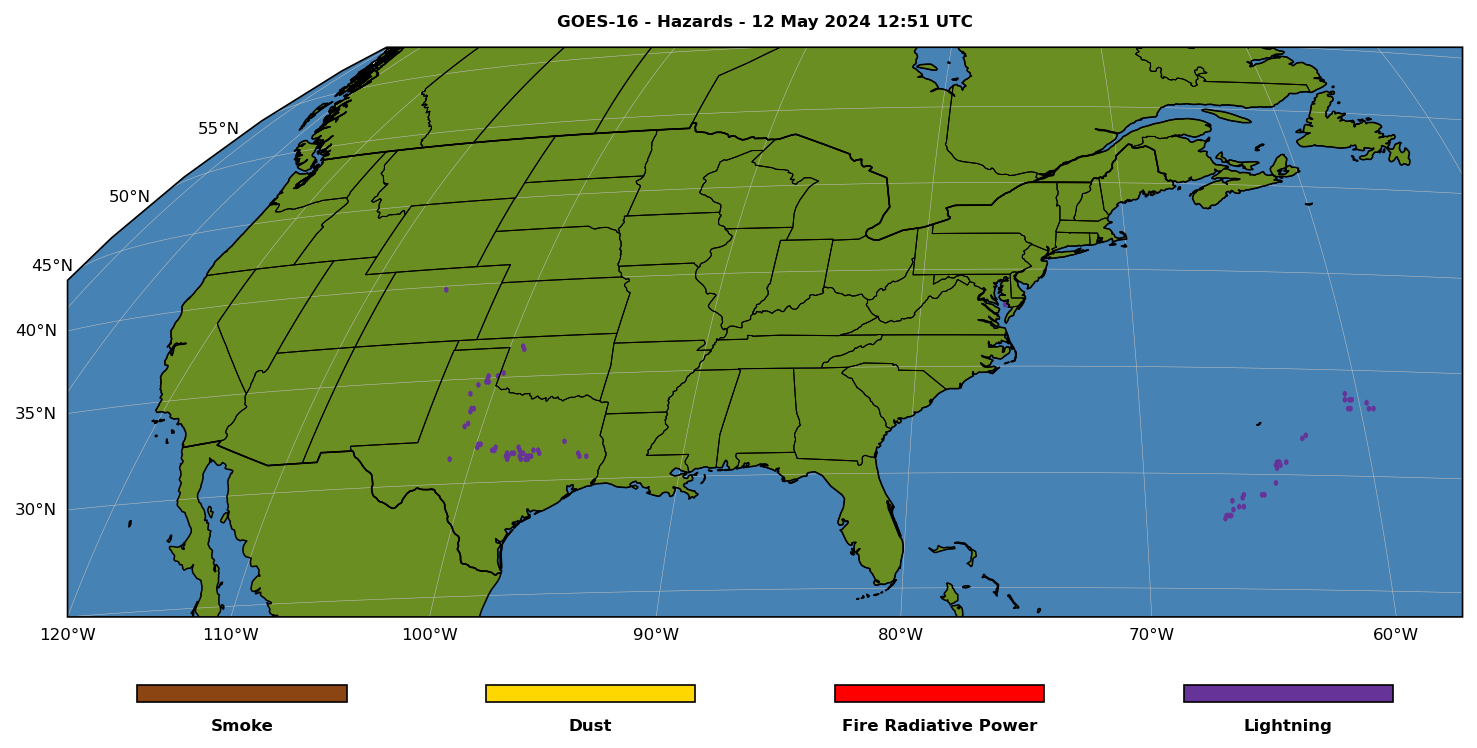

In [21]:
# Import necessary libraries for data visualization and geographical mapping.
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Initialize the figure with a specified size and resolution to ensure detailed visualization.
fig = plt.figure(figsize=(12, 12), dpi=150)

# Retrieve projection parameters from satellite metadata to accurately project data onto a map.
projection_variables = adpc_ds.goes_imager_projection
satellite_height = projection_variables.perspective_point_height
semi_major_axis = projection_variables.semi_major_axis
semi_minor_axis = projection_variables.semi_minor_axis
central_longitude = projection_variables.longitude_of_projection_origin

# Define the geostationary projection using satellite metadata. This projection is crucial for accurately plotting satellite imagery data.
globe = ccrs.Globe(semimajor_axis=semi_major_axis, semiminor_axis=semi_minor_axis)
geo_projection = ccrs.Geostationary(central_longitude=central_longitude, satellite_height=satellite_height, globe=globe, sweep_axis='x')
ax = plt.axes(projection=geo_projection)

# Set up map gridlines and label styles for readability. This enhances the map's usability for analysis and presentations.
gl = ax.gridlines(draw_labels=True, linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 5), color='silver', zorder=3)
gl.right_labels = None
gl.top_labels = None
gl.ypadding = 5
gl.xpadding = 5
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Add geographical features to the map for context. These include borders, coastlines, and different landforms.
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m'), linewidth=0.75, facecolor='none', edgecolor='k', zorder=3)
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces', scale='50m'), linewidth=0.5, facecolor='none', edgecolor='k', zorder=3)
ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='ocean', scale='50m'), facecolor='steelblue')
ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m'), facecolor='olivedrab')

# Define the geographical extent for the map based on the area of interest. This focuses the map view on relevant regions.
box_array = [-120, -57, 25, 55]
ax.set_extent(box_array, ccrs.PlateCarree())

# Setup colormaps for different types of environmental hazards. These visual aids help in quickly identifying and assessing different phenomena.
cmap1 = mpl.colors.ListedColormap(['saddlebrown'])  # Smoke
cmap2 = mpl.colors.ListedColormap(['gold'])  # Dust
cmap3 = mpl.colors.ListedColormap(['red'])  # Fire Radiative Power
cmap4 = mpl.colors.ListedColormap(['rebeccapurple'])  # Lightning

# Plot the data layers for smoke, dust, fire, and lightning. Each layer uses a specific colormap for clear distinction.
plot1 = ax.pcolormesh(lon, lat, smoke_detection, cmap=cmap1, transform=ccrs.PlateCarree(), zorder=2)
plot2 = ax.pcolormesh(lon, lat, dust_detection, cmap=cmap2, transform=ccrs.PlateCarree(), zorder=2)
plot3 = ax.pcolormesh(lon, lat, frp, cmap=cmap3, transform=ccrs.PlateCarree())
plot4 = ax.hexbin(flash_lon, flash_lat, gridsize=500, bins='log', transform=ccrs.PlateCarree(), cmap=cmap4, vmin=1, vmax=30, zorder=2)

# Add and format colorbars for each hazard type to assist in data interpretation and analysis.
cb1_ax = ax.inset_axes([0.05, -0.15, 0.15, 0.03])
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap1, orientation='horizontal')
cb1.set_label('Smoke', size=8, weight='bold')
cb1.ax.xaxis.set_major_formatter(ticker.NullFormatter())
cb1.ax.tick_params(which='major', length=0)

cb2_ax = ax.inset_axes([0.3, -0.15, 0.15, 0.03])
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, orientation='horizontal')
cb2.set_label('Dust', size=8, weight='bold')
cb2.ax.xaxis.set_major_formatter(ticker.NullFormatter())
cb2.ax.tick_params(which='major', length=0)

cb3_ax = ax.inset_axes([0.55, -0.15, 0.15, 0.03])
cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap=cmap3, orientation='horizontal')
cb3.set_label('Fire Radiative Power', size=8, weight='bold')
cb3.ax.xaxis.set_major_formatter(ticker.NullFormatter())
cb3.ax.tick_params(which='major', length=0)

cb4_ax = ax.inset_axes([0.8, -0.15, 0.15, 0.03])
cb4 = mpl.colorbar.ColorbarBase(cb4_ax, cmap=cmap4, orientation='horizontal')
cb4.set_label('Lightning', size=8, weight='bold')
cb4.ax.xaxis.set_major_formatter(ticker.NullFormatter())
cb4.ax.tick_params(which='major', length=0)

# Format and display the title of the map, which includes detailed satellite, hazard, and observation time information.
file_name = adpc_files[-1].split('/')[-1]
julian = datetime.strptime(file_name.split('_')[3][1:8], '%Y%j').date()
observation_date = julian.strftime('%d %B %Y')
image_title = 'GOES-' + file_name.split('_')[2][1:] + ' - Hazards - ' + observation_date + ' ' + file_name.split('_')[3][8:10] + ':' + file_name.split('_')[3][10:12] + ' UTC'
plt.title(image_title, pad=10, size=8, weight='bold')

# Display the completed figure, showing all layers and features.
plt.show()

# Close the figure after displaying to free up system resources.
plt.close()